<a href="https://colab.research.google.com/github/gilarndw/COTS-Classification/blob/main/COTSImageClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
data_dir = '/content/drive/My Drive/datasets/COTS/'

In [ ]:
# For Data Processing & ML Models
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as cm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.losses import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.preprocessing.image import load_img
from PIL import Image, ImageEnhance

# For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Miscellaneous
from tqdm import tqdm
import time
import os
import random
from IPython import display

In [ ]:
all_paths = []
all_labels = []

for label in os.listdir(data_dir):
  for image in os.listdir(data_dir+label):
    all_paths.append(data_dir+label+'/'+image)
    all_labels.append(label)

  all_paths, all_labels = shuffle(all_paths, all_labels)

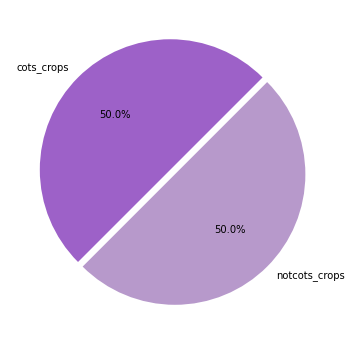

In [ ]:
#Visualize data percentage between two sets of images

plt.figure(figsize=(14,6))
colors = ["#9D61C8", "#B799CB", "#ae7cd1", "#a670cd"]
plt.pie([len([x for x in all_labels if x=='cots_crops']),
         len([x for x in all_labels if x=='notcots_crops'])],
        labels=['cots_crops','notcots_crops'],
        colors=colors, autopct='%.1f%%', explode=(0.0,0.05),
        startangle=45);

The data is balanced. same amount of images between two categories

In [ ]:
#split the data for training and validation
#80% for training and 20% for validation

x_train_paths, x_val_paths, y_train, y_val = train_test_split(all_paths, all_labels, test_size=0.2, random_state=42)

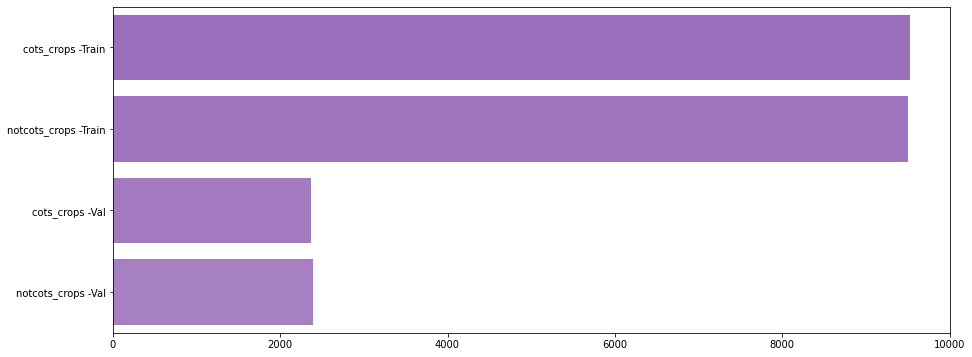

In [ ]:
plt.figure(figsize=(15, 6))
sns.barplot(x=[len([x for x in y_train if x=='cots_crops']),
               len([x for x in y_train if x=='notcots_crops']),
               len([x for x in y_val if x=='cots_crops']),
               len([x for x in y_val if x=='notcots_crops'])],
            y=['cots_crops -Train',
               'notcots_crops -Train',
               'cots_crops -Val',
               'notcots_crops -Val'],
           palette = sns.light_palette("#9D61C8", reverse = True, n_colors = int(19 * 1.2)))
plt.show()

In [ ]:
#Data Augmentation

def augment_image(image):
    if random.uniform(0,1)>0.5:
        image = np.fliplr(image)
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.6,1.4))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.6,1.4))
    image = ImageEnhance.Color(image).enhance(random.uniform(0.6,1.4))
    return image

In [ ]:
IMAGE_SIZE = 128

def open_images(paths, augment=True):
    images = []
    for path in paths:
        image = load_img(path, target_size=(IMAGE_SIZE,IMAGE_SIZE))
        image = np.array(image)
        if augment:
            image = augment_image(image)
        image = np.array(image)/255.0
        images.append(image)
    return np.array(images)

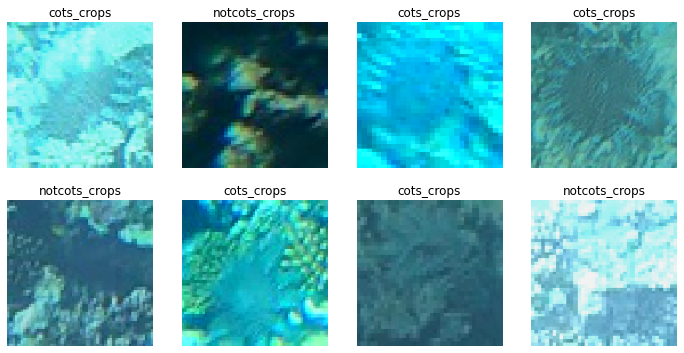

In [ ]:
images = open_images(x_train_paths[50:59])
labels = y_train[50:59]
fig = plt.figure(figsize=(12, 6))
for x in range(1, 9):
    fig.add_subplot(2, 4, x)
    plt.axis('off')
    plt.title(labels[x])
    plt.imshow(images[x])
plt.show()

Here are the examples of images that have been enhanced

In [ ]:
#Data Augmentation, this function is to normalize the data, and augments the images

unique_labels = os.listdir(data_dir)

In [ ]:
def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

In [ ]:
def data_gen(paths, labels, batch_size=12, epochs=3, augment=True):
    for _ in range(epochs):
        for x in range(0, len(paths), batch_size):
            batch_paths = paths[x:x+batch_size]
            batch_images = open_images(batch_paths, augment=augment)
            batch_labels = labels[x:x+batch_size]
            batch_labels = encode_label(batch_labels)
            yield batch_images, batch_labels

In [ ]:
#Building the model
base_model = tf.keras.applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), weights='imagenet', include_top=False)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=(IMAGE_SIZE,IMAGE_SIZE,3)))
model.add(base_model)

model.add(tf.keras.layers.GlobalAveragePooling2D())

model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(512))
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(256))
model.add(tf.keras.layers.Activation("relu"))

model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(len(unique_labels)))
model.add(tf.keras.layers.Activation("softmax"))


model.compile(loss = "sparse_categorical_crossentropy", optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002), metrics = ["sparse_categorical_accuracy"])


9420800/9406464 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [ ]:
batch_size = 32
steps = int(len(x_train_paths)/batch_size)
epochs = 6
history = model.fit(data_gen(x_train_paths, y_train, batch_size=batch_size, epochs=epochs, augment=True),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/6
594/594 [==============================] - 6525s 11s/step - loss: 0.2484 - sparse_categorical_accuracy: 0.8940
Epoch 2/6
594/594 [==============================] - 1089s 2s/step - loss: 0.1010 - sparse_categorical_accuracy: 0.9611
Epoch 3/6
594/594 [==============================] - 1087s 2s/step - loss: 0.0635 - sparse_categorical_accuracy: 0.9778
Epoch 4/6
594/594 [==============================] - 1088s 2s/step - loss: 0.0501 - sparse_categorical_accuracy: 0.9805
Epoch 5/6
594/594 [==============================] - 1085s 2s/step - loss: 0.0420 - sparse_categorical_accuracy: 0.9850
Epoch 6/6
594/594 [==============================] - 1088s 2s/step - loss: 0.0378 - sparse_categorical_accuracy: 0.9871


In [ ]:
batch_size=32
steps = int(len(x_val_paths)/batch_size)
y_pred = []
y_true = []
t1 = time.perf_counter()
for x,y in tqdm(data_gen(x_val_paths, y_val, batch_size=batch_size, epochs=1, augment=False), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in decode_label(pred):
        y_pred.append(i)
    for i in decode_label(y):
        y_true.append(i)
t2 = time.perf_counter()
display.clear_output()
print("Time taken to predict", len(x_val_paths), "samples is", t2-t1, "seconds")
print("Average Prediction Speed:", len(x_val_paths)/(t2-t1), "image per second")

Time taken to predict 4760 samples is 1693.6075258439996 seconds
Average Prediction Speed: 2.8105685215515805 image per second


In [ ]:
print(classification_report(y_true, y_pred))

               precision    recall  f1-score   support

   cots_crops       1.00      0.93      0.96      2371
notcots_crops       0.94      1.00      0.97      2389

     accuracy                           0.96      4760
    macro avg       0.97      0.96      0.96      4760
 weighted avg       0.97      0.96      0.96      4760

